# __Compact Convolutional Transformers__

Pytorch reimplementation of this Keras [tutorial](https://keras.io/examples/vision/cct/)

As discussed in the ViT paper, a Transformer-based architecture for vision often requires typically a larger dataset than usual, as well as a longer pre-training schedule. This is primarily because, unlike CNNs, a typical Transformer-based architecture do not have well-informed inductive biases (i.e., CNNs exploit locality: features are generated using local pixels and then combined hierarchically). 

This begs the question: __can't we combine the benefits of convolution and the benefits of Transformers in a single netweok architecture?__ These benefits include paarameter-efficiency, and self-attention to process long-range and global dependencies (înteractions between different regions in an image).

In [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704), Hassani et al. present an approach for doing exactly this: the __Compact Convolutional Transformer (CCT)__ architecture.

## Imports

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## __The CCT Tokenizer__

In a standard ViT, images are organized into uniform _non-overlapping_ patches. This simple patching and embedding method has a few limitations, in particular: loss of information along boundary regions. This is important for a neural network to exploit the locality information. Since CNNs are quite good at exploiting locality information, the authors introduce and all-convolution mini-network to produce image patches.

In [2]:
class CCTConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,  padding, pooling_kernel_size, pooling_stride, act_layer=nn.ReLU):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding='valid', bias=False),
                                        act_layer(),
                                        nn.ZeroPad2d(padding),
                                        nn.MaxPool2d(pooling_kernel_size, pooling_stride))

        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        return self.conv_block(x)

class CCT_Tokenizer(nn.Module):

    def __init__(self, img_size, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pooling_kernel_size=3, pooling_stride=2):
        super().__init__()

        layers = []
        for i in range(len(out_channels)):
            n_in = in_channels if i == 0 else out_channels[i-1]
            n_out = out_channels[i]
            layers.append(CCTConvBlock(in_channels=n_in, 
                                        out_channels=n_out,
                                        kernel_size=kernel_size, 
                                        stride=stride,
                                        padding=padding,
                                        pooling_kernel_size=pooling_kernel_size,
                                        pooling_stride=pooling_stride))

        self.tokenizer = nn.Sequential(*layers)
        with torch.no_grad(): # dummy forward to get num patches
            out = self(torch.randn((1, in_channels, img_size[0], img_size[0])))
            _, self.num_patches, _ = out.shape

    def forward(self, x):
        x = self.tokenizer(x)
        B, C, H, W = x.shape
        x = x.reshape((B, C, -1)).permute(0,2,1).contiguous()
        return x

## __Sequence Pooling__

Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only the feature map corresponding to the class token is pooled and is then used for the subsequent classification task (or any other downstream task).

In [3]:
class SequencePooling(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.attention = nn.Linear(emb_dim, 1)
    
    def forward(self, x):
        attn_weights = torch.nn.functional.softmax(self.attention(x), dim=1)
        attn_weights = attn_weights.permute(0,2,1).contiguous()
        weighted_representation = (attn_weights @ x).squeeze(1)
        return weighted_representation

## __CCT: Compact Convolutional Transformer__

In [4]:
# Tranformer code mostly copy-pasted from: https://github.com/facebookresearch/dino/blob/main/vision_transformer.py

from torch.nn.init import trunc_normal_

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class CCT_Transformer(nn.Module):

    def __init__(self, img_size, in_channels, emb_dim, n_classes, num_heads, depth, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        
        super().__init__()
        self.img_size = img_size
        self.in_channels = in_channels
        self.emb_dim = emb_dim
        self.num_heads = num_heads

        self.tokenizer = CCT_Tokenizer(img_size=self.img_size, in_channels=self.in_channels, out_channels=[64, self.emb_dim])
        self.pos_embed = nn.Parameter(torch.zeros(1, self.tokenizer.num_patches, emb_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=emb_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(emb_dim)

        # classifier_head 
        self.weighted_representation = SequencePooling(emb_dim=self.emb_dim)
        self.classification_layer = nn.Linear(self.emb_dim, n_classes)
            
        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def prepare_tokens(self, x):
        x = self.tokenizer(x)
        x = x + self.pos_embed
        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        weighted_repr = self.weighted_representation(x)
        logits = self.classification_layer(weighted_repr)
        return logits

    def get_weighted_representation(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        weighted_repr = self.weighted_representation(x)
        return weighted_repr
    
    def get_last_attention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

## Hyperparameters and constants

In [5]:
emb_dim = 128
num_heads = 2
depth = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32
image_ch = 3

## Dataset

In [6]:
tfms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop((image_size, image_size)),
     transforms.RandomHorizontalFlip()
    ])

ds_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tfms)
ds_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tfms)
n_classes = len(ds_train.classes)
print(f'# Classes: {n_classes} -> {ds_train.classes}')

Files already downloaded and verified
Files already downloaded and verified
# Classes: 10 -> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Model

In [7]:
from torchsummary import summary

model = CCT_Transformer(img_size=[image_size], 
                        in_channels=image_ch,
                        emb_dim=emb_dim,
                        n_classes=n_classes,
                        num_heads=num_heads,
                        depth=depth,
                        drop_path_rate=stochastic_depth_rate)

_ = summary(model, (image_ch, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─CCT_Tokenizer: 1-1                     [-1, 49, 128]             --
|    └─Sequential: 2-1                   [-1, 128, 7, 7]           --
|    |    └─CCTConvBlock: 3-1            [-1, 64, 15, 15]          1,728
|    |    └─CCTConvBlock: 3-2            [-1, 128, 7, 7]           73,728
├─Dropout: 1-2                           [-1, 49, 128]             --
├─ModuleList: 1                          []                        --
|    └─Block: 2-2                        [-1, 49, 128]             --
|    |    └─LayerNorm: 3-3               [-1, 49, 128]             256
|    |    └─Attention: 3-4               [-1, 49, 128]             65,664
|    |    └─Identity: 3-5                [-1, 49, 128]             --
|    |    └─LayerNorm: 3-6               [-1, 49, 128]             256
|    |    └─Mlp: 3-7                     [-1, 49, 128]             131,712
|    |    └─Identity: 3-8                [-1, 49, 128]             

## Training

In [8]:
import torch.optim as optim
import torchmetrics

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

[Epoch 1/30] Train loss: 1.7874 - Test loss: 1.5352 Train accuracy: 38.55 % - Test  accuracy: 51.19 %
[Epoch 2/30] Train loss: 1.4902 - Test loss: 1.4226 Train accuracy: 54.238 % - Test  accuracy: 57.68 %
[Epoch 3/30] Train loss: 1.3581 - Test loss: 1.2879 Train accuracy: 60.958 % - Test  accuracy: 64.14 %
[Epoch 4/30] Train loss: 1.2713 - Test loss: 1.254 Train accuracy: 65.264 % - Test  accuracy: 65.63 %
[Epoch 5/30] Train loss: 1.2006 - Test loss: 1.2182 Train accuracy: 68.614 % - Test  accuracy: 67.54 %
[Epoch 6/30] Train loss: 1.1518 - Test loss: 1.1829 Train accuracy: 71.19 % - Test  accuracy: 69.62 %
[Epoch 7/30] Train loss: 1.1113 - Test loss: 1.1786 Train accuracy: 72.852 % - Test  accuracy: 69.61 %
[Epoch 8/30] Train loss: 1.0816 - Test loss: 1.1387 Train accuracy: 74.306 % - Test  accuracy: 71.5 %
[Epoch 9/30] Train loss: 1.0387 - Test loss: 1.1028 Train accuracy: 76.326 % - Test  accuracy: 73.57 %
[Epoch 10/30] Train loss: 1.0045 - Test loss: 1.0493 Train accuracy: 78.038 %

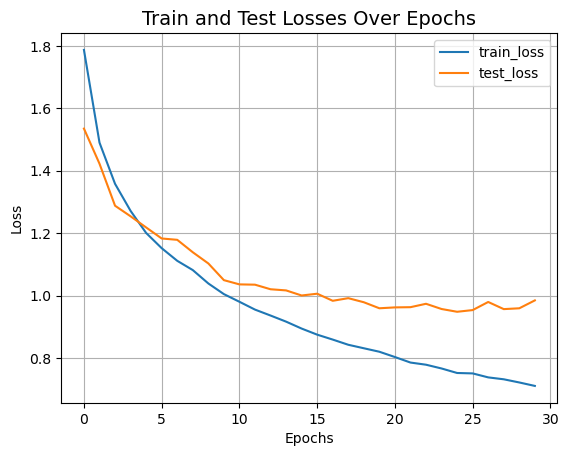

In [9]:
losses_train = []
losses_test = []
model.to(device)

for epoch_idx in range(num_epochs):
    
    model = model.train()
    train_running_loss = 0.0
    train_total = 0
    train_correct = 0
    
    for batch in dl_train:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * x.shape[0]
        # Accuracy metrics
        _, predicted_class = torch.max(logits.data, dim=1)
        train_total += y.size(0)
        train_correct += (predicted_class == y).sum().item()

    train_running_loss = train_running_loss / len(dl_train.dataset)
    losses_train.append(train_running_loss)
    
    model = model.eval()    
    test_running_loss = 0.0
    test_total = 0
    test_correct = 0
    
    for batch in dl_test:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x)
            loss = criterion(logits, y)
        
        test_running_loss += loss.item() * x.shape[0]
        # Accuracy metrics
        _, predicted_class = torch.max(logits.data, dim=1)
        test_total += y.size(0)
        test_correct += (predicted_class == y).sum().item()

    test_running_loss = test_running_loss / len(dl_test.dataset)
    losses_test.append(test_running_loss)

    print(f'[Epoch {epoch_idx+1}/{num_epochs}] Train loss: {np.around(train_running_loss, 4)} - Test loss: {np.around(test_running_loss, 4)} Train accuracy: {np.around(100 * train_correct / train_total, 4)} % - Test accuracy: {np.around(100 * test_correct / test_total, 4)} %')

losses_train = np.array(losses_train)
losses_test = np.array(losses_test)

plt.plot(losses_train, label="train_loss")
plt.plot(losses_test, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()